In [1]:
from transformers import GPT2LMHeadModel

In [2]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
sd_hf = model_hf.state_dict()
for k, v in sd_hf.items():
    print(k, v.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

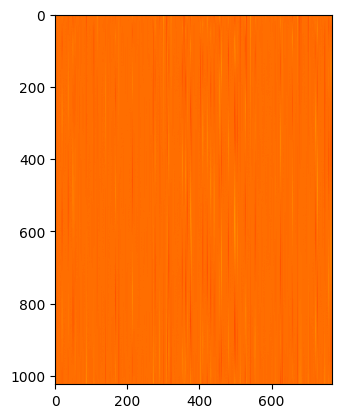

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="hot")

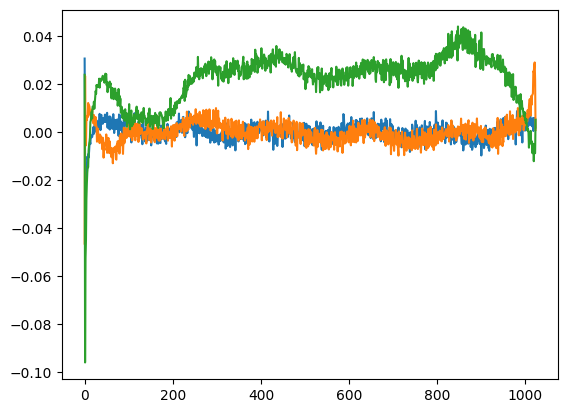

In [4]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 500])
plt.plot(sd_hf["transformer.wpe.weight"][:, 150])
plt.plot(sd_hf["transformer.wpe.weight"][:, 250])

In [5]:
sd_hf["transformer.wpe.weight"][:, 500]

tensor([ 0.0305, -0.0142, -0.0238,  ...,  0.0041,  0.0057,  0.0018])

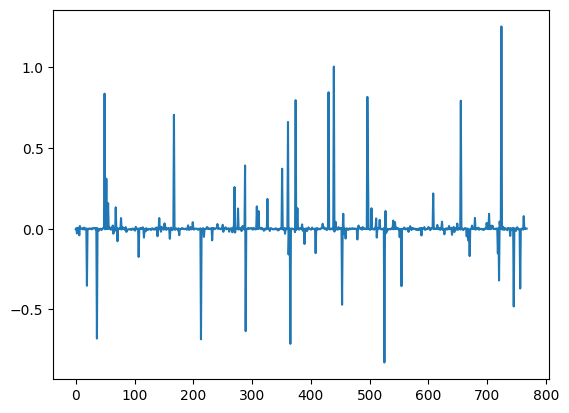

In [6]:
plt.plot(sd_hf["transformer.wpe.weight"][500, :])

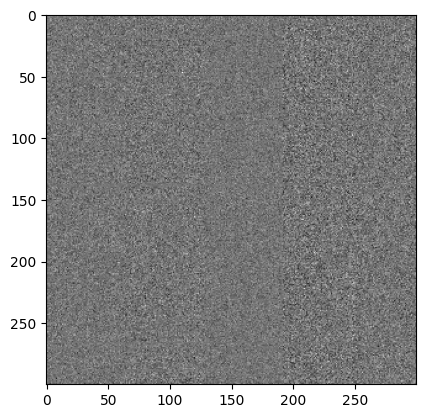

In [7]:
plt.imshow(sd_hf["transformer.h.0.attn.c_attn.weight"][:300,:300], cmap="gray")

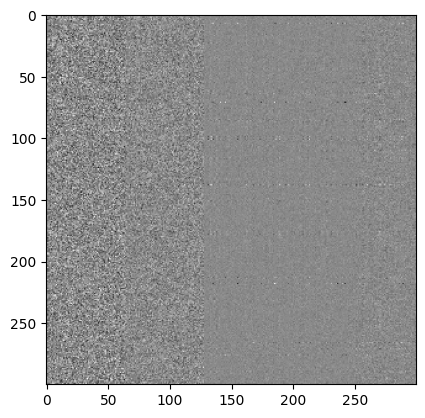

In [8]:
plt.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:300,:300], cmap="gray")

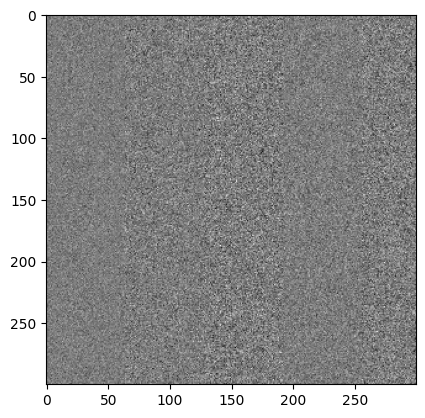

In [9]:
plt.imshow(sd_hf["transformer.h.2.attn.c_attn.weight"][:300,:300], cmap="gray")

In [10]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, I'm writing a new language for you. But first, I'd like to tell you about the language itself"},
 {'generated_text': "Hello, I'm a language model, and I'm trying to be as expressive as possible. In order to be expressive, it is necessary to know"},
 {'generated_text': "Hello, I'm a language model, so I don't get much of a license anymore, but I'm probably more familiar with other languages on that"},
 {'generated_text': "Hello, I'm a language model, a functional model... It's not me, it's me!\n\nI won't bore you with how"},
 {'generated_text': "Hello, I'm a language model, not an object model.\n\nIn a nutshell, I need to give language model a set of properties that"}]

In [ ]:
from dataclasses import dataclass
import torch 
import torch.nn as nn
from torch.nn import functional as F
import math

num_return_sequences = 5
max_length = 30
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()
model.to(device)

# prefix tokens
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode("Hello, I'm a language model,")
tokens = torch.tensor(tokens, dtype=torch.long) # (8,)
tokens = tokens.unsqueeze(0).repeat(num_return_sequences, 1) # (5, 8)
x = tokens.to(device)

torch.manual_seed(42)
torch.cuda.manual_seed(42)
while x.size(1) < max_length:
    with torch.no_grad():
        logits = model(x)[0] # B, T, vocab size
        # take the logits at the last position
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        # do top-k sampling of 50
        # topk_probs shape = (B, 50), topk_indicies shape = (B, 50)
        topk_probs, topk_indicies = torch.topk(probs, 50, dim=-1)
        ix = torch.multinomial(topk_probs, num_samples=1) # shape = (B, 1)
        xcol = torch.gather(topk_indicies, -1, ix) # shape = (B, 1)
        x = torch.cat((x, xcol), dim=1)

for i in range(num_return_sequences):
    tokens = x[i, :max_length].tolist()
    decoded = enc.decode(tokens)
    print(">", decoded)

> Hello, I'm a language model, not a science. I'm a language designer. I want to write, I want to think. I want
> Hello, I'm a language model, I use an English sentence structure, I like words over sentences.

"That's OK I'll look
> Hello, I'm a language model, not just another language." This isn't a "language model?" It's an idea. So far, what
> Hello, I'm a language model, not a programming model. I'm not a theoretical computer model - you read that right - because my ideas are
> Hello, I'm a language model, I teach myself.

I want to know more about how languages work and why they could be used.


In [25]:
# tiny shakespeare dataset
#!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open("input.txt", "r") as f:
    text = f.read()
data = text[:1000]
print(data[:100])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--2024-06-15 20:48:31--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2024-06-15 20:48:31 (29.7 MB/s) - ‘input.txt’ saved [1115394/1115394]

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [26]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(data)
print(tokens[:100])

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13, 198, 198, 5962, 22307, 25, 198, 1639, 389, 477, 12939, 2138, 284, 4656, 621, 284, 1145, 680, 30, 198, 198, 3237, 25, 198, 4965, 5634, 13, 12939, 13, 198, 198, 5962, 22307, 25, 198, 5962, 11, 345, 760, 327, 1872, 385, 1526, 28599, 318, 4039, 4472, 284, 262, 661, 13, 198, 198, 3237, 25, 198, 1135, 760, 470, 11, 356, 760, 470, 13, 198, 198, 5962, 22307, 25, 198, 5756, 514, 1494, 683, 11, 290, 356]


Min Train Loss: 3.450244
Min Validation Loss: 3.73986
Max Hellaswag eval: 0.2605


/tmp/ipykernel_127743/3131048263.py:62: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0.0, 4.0)


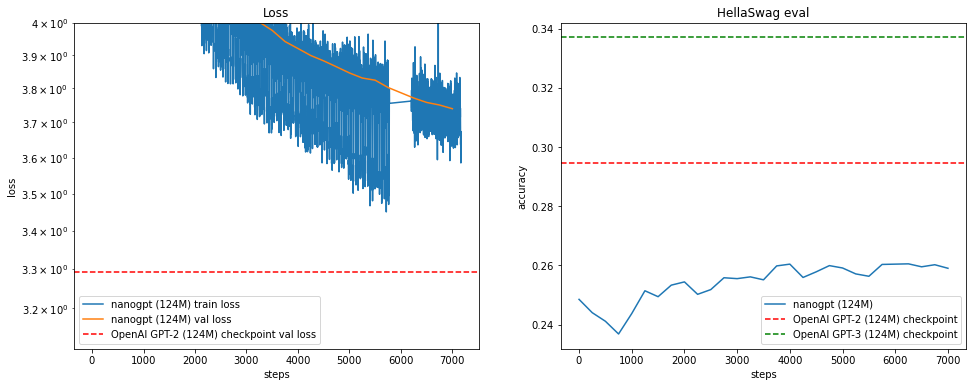

In [9]:
# parse and visualize the logfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # HellaSwag for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

# load the log file
with open("log/log.txt", "r") as f:
    lines = f.readlines()

# parse the individual lines, group by stream (train,val,hella)
streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

# convert each stream from {step: val} to (steps[], vals[])
# so it's easier for plotting
streams_xy = {}
for k, v in streams.items():
    # get all (step, val) items, sort them
    xy = sorted(list(v.items()))
    # unpack the list of tuples to tuple of lists
    streams_xy[k] = list(zip(*xy))

# create figure
plt.figure(figsize=(16, 6))

# Panel 1: losses: both train and val
plt.subplot(121)
xs, ys = streams_xy["train"] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'nanogpt ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"] # validation loss
plt.plot(xs, ys, label=f'nanogpt ({sz}) val loss')
# horizontal line at GPT-2 baseline
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(0.0, 4.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag eval
plt.subplot(122)
xs, ys = streams_xy["hella"] # HellaSwag eval
ys = np.array(ys)
plt.plot(xs, ys, label=f"nanogpt ({sz})")
# horizontal line at GPT-2 baseline
if hella2_baseline:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
if hella3_baseline:
    plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) checkpoint")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag eval")
print("Max Hellaswag eval:", max(ys))

In [5]:
from train_gpt2 import *
model = GPT(GPTConfig(vocab_size=50304))
model.load_state_dict(torch.load("log/model_05000.pt"))
model.eval()

using device: cuda
total batch size: 524288, grad_accum_steps: 32
ddp: False, rank: 0, local_rank: 0, world_size: 1
found 99 shards for train
found 1 shards for val
model compiled: False
num decayed parameter tensors: 50, with 124,354,560 parameters
num non-decayed parameter tensors: 98, with 121,344 parameters
using fused AdamW: True
validation loss: 10.94992
HellaSwag accuracy: 2495/10042=0.2485
rank 0 sample 0: Hello, I'm a language model,CHR 351ointmentprotantically surrounded flaw TCUorigin Effective surrounded senate rodents�oviribution Feinstein Homericulty Tigers Yang bearings bearingsleased
rank 0 sample 1: Hello, I'm a language model,iggs Socialism Yangointment rodents contributors investigatesteness emulator toughestikoReillyFine fluffy iCloudAbsTesla Frames465ARE traders flaw cuisine exponentially
rank 0 sample 2: Hello, I'm a language model, glimpserint236udzee unve Neighvanceces arise Account Student Privacy Privacy beloved Christina Patterns sugg Sche continental iCloudf

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.07 GiB. GPU 

In [ ]:
sd_hf = model.state_dict()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(sd_hf["transformer.wpe.weight"], cmap="hot")

In [ ]:
plt.plot(sd_hf["transformer.wpe.weight"][:, 500])
plt.plot(sd_hf["transformer.wpe.weight"][:, 150])
plt.plot(sd_hf["transformer.wpe.weight"][:, 250])

In [ ]:
plt.imshow(sd_hf["transformer.h.0.attn.c_attn.weight"][:300,:300], cmap="gray")

In [ ]:
plt.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:300,:300], cmap="gray")

In [ ]:
plt.imshow(sd_hf["transformer.h.2.attn.c_attn.weight"][:300,:300], cmap="gray")